<br>
<u>Notebook Ten</u> | 
<a href=https://leone.gdn/DLL target=_blank>Report</a> | 
<a href=https://github.com/andrealeone/DLL>Repository</a>
<br><br>
<b>Task 2: Siamese Net</b><br><br>
Andrea Leone, Alessandro E. Piotti<br>
Deep Learning Lab — University of Trento<br>
December 2021
<hr><br><br>

In [1]:
import project 

import os
import numpy             as np
import scipy             as sp
import pandas            as pd
import matplotlib.pyplot as plt
import random
import pickle
import collections

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchvision

from tqdm.notebook   import tqdm

project.notebook()

In [2]:
_, annotations = project.load_resources() 

<hr><br><br>

## Content-Based Image Retrieval<br>with Siamese Networks

<br><br>Load the pickled data (from nb. 8)

In [3]:
with open('./data/image_dict.train.v2.pkl', 'rb') as file: 
    dictionary = pickle.load(file) 

<br><br>Generate triplets on demand using training id labels

In [4]:
ids = list( dictionary.keys() ) 

def generate_triplets(tmf=2): 
    
    triplets = list() 
    for _id in ids: 
        
        tmp_ids = list(ids)
        for a,_ in dictionary[_id]:
            
            if _id in tmp_ids:
                tmp_ids.remove(_id)
            
            for _ in range(tmf):
                
                p = random.choice( dictionary[_id] )[0] 
                n = dictionary[ random.choice(tmp_ids) ][0][0] 
                
                triplets.append([ a, p, n ])
    
    return triplets

<br><br>Define the test sample-encoding network

In [5]:
class Network(nn.Module): 
    
    def __init__(self):
        super().__init__()
        
        self.cnv1 = nn.Conv2d( 3, 30, kernel_size=(5,5))
        self.cnv2 = nn.Conv2d(30, 20, kernel_size=(4,4))
        self.cnv3 = nn.Conv2d(20, 10, kernel_size=(3,3))
        
        self.bn1  = nn.BatchNorm2d(30)
        self.bn2  = nn.BatchNorm2d(20)
        self.bn3  = nn.BatchNorm2d(10)
        
        self.pool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2))
        self.drop = nn.Dropout(p=0.25)
        
        self.fc1  = nn.Linear(480, 240)
        self.fc2  = nn.Linear(240, 120)
        self.fc3  = nn.Linear(120,  10)
        self.fc4  = nn.Linear( 10,  10)
        self.fc5  = nn.Linear( 10,   2)
    
    def forward(self, x):
        
        x = nn.functional.relu( self.cnv1(x) )
        x = self.bn1(x)
        x = self.pool(x)
        
        x = nn.functional.relu( self.cnv2(x) )
        x = self.bn2(x)
        x = self.pool(x)
        
        x = nn.functional.relu( self.cnv3(x) )
        x = self.bn3(x)
        x = self.pool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.drop(x)
        
        x = nn.functional.relu( self.fc1(x) )
        x = nn.functional.relu( self.fc2(x) )
        x = nn.functional.relu( self.fc3(x) )
        x = nn.functional.relu( self.fc4(x) )
        x = nn.functional.tanh( self.fc5(x) )
        
        return x

In [6]:
v = '4'                         # model version 
e =  0                          # starting epoch


model = Network()

optimizer = optim.Adam(model.parameters())
criterion = nn.TripletMarginLoss(
    margin=1.0, reduction='mean'
)

if e > 0:
    w = './models/siamese_cnn.v{}.x{}.net'.format(v, e)
    model.load_state_dict( torch.load(w) )

<br><br>Train the siamese network

In [ ]:
epochs =   10 
li     = 1000

model.train()

performance = list()
for epoch in range(epochs): 
    
    model_name = 'siamese_cnn.v{}.x{}.net'.format(v, epoch+e+1)
    print('\n{}) v{} → {}'.format(epoch+e+1, v, model_name))
    
    triplets = generate_triplets(tmf=3)
    random.shuffle( triplets ) 
    
    current_loss = 0.0
    for i, triplet in tqdm(list( enumerate(triplets) )):
        
        a, p, n = triplet
        
        optimizer.zero_grad()
        
        a = model(a)
        p = model(p)
        n = model(n)
        
        loss = criterion( a, p, n )
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
        performance.append( (epoch, loss.item()) )
        
        if (i+1) % li == 0:
            print('loss  %5d:  %.3f' % (i+1, current_loss/li))
            current_loss = 0.0

        project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | average loss      | notes
#                    |        |                   |
# siamese_cnn_v4     |  1     | 0.58715686274509  |
# siamese_cnn_v4     |  2     | 0.30666666666666  |
# siamese_cnn_v4     |  3     | 0.17466666666666  |
# siamese_cnn_v4     |  4     | 0.13478431372549  |
# siamese_cnn_v4     |  5     | 0.12039215686274  |
# siamese_cnn_v4     |  6     | 0.10629411764705  |
# siamese_cnn_v4     |  7     | 0.09441176470588  |
# siamese_cnn_v4     |  8     | 0.09631372549019  |
# siamese_cnn_v4     |  9     | 0.09070588235294  |
# siamese_cnn_v4     | 10     | 0.11135294117647  |
# siamese_cnn_v4     | 11     | 0.14139215686274  |
# siamese_cnn_v4     | 12     | 0.19764705882352  |
# siamese_cnn_v4     | 13     | 0.19994117647058  |
# siamese_cnn_v4     | 14     | 0.18950980392156  |
# siamese_cnn_v4     | 15     | 0.18447058823529  |
# siamese_cnn_v4.2   | 16     | 0.35505882352941  | increased TML margin
# siamese_cnn_v4.2   | 17     | 0.37145098039215  |  "
# siamese_cnn_v4.2   | 18     | 0.38358823529411  |  "
# siamese_cnn_v4.2   | 19     | 0.36721568627450  |  "
# siamese_cnn_v4.2   | 20     | 0.37098039215686  |  "
# siamese_cnn_v4.2   | 21     | 0.35529411764705  |  "
# siamese_cnn_v4     | 22     | 0.11717647058823  | 
# siamese_cnn_v4     | 23     | 0.16431372549019  |
# siamese_cnn_v4     | 24     | 0.15760784313725  |
# siamese_cnn_v4     | 25     | 0.15139215686274  |
# siamese_cnn_v4     | 26     | 0.14656862745098  |
# siamese_cnn_v4     | 27     | 0.15670588235294  |
# siamese_cnn_v4     | 28     | 0.14998039215686  |
# siamese_cnn_v4     | 29     | 0.15960784313725  |
# siamese_cnn_v4     | 30     | 0.14258823529411  |

<br><br>Show performance

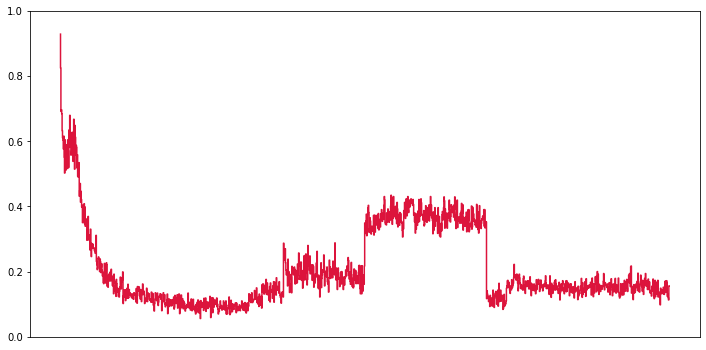

In [7]:
dat = './data/siamese_network.v4_0.performance.dat' 
project.plot_performance(dat, lims=(0,1)) 

Show performance of previous attempt

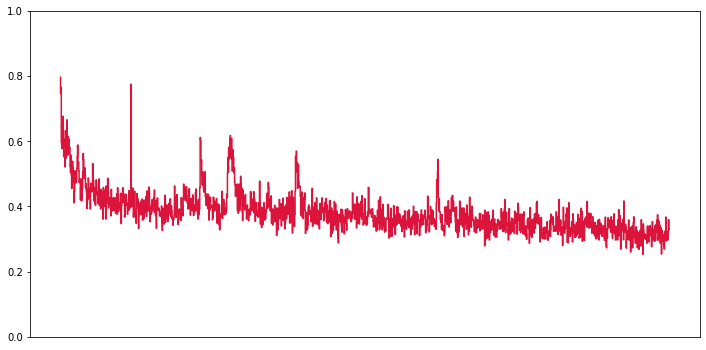

In [8]:
dat = './data/siamese_network.v4_2.performance.dat' 
project.plot_performance(dat, lims=(0,1)) 

<br><br>